# Importing basic modules, libraries etc for general use

In [0]:
# Import modules:

# Create a connection to the Google Colab server

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# General use
import time

# Data manipulation and cleaning
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Web Scraping
import requests
import json
from pandas.io.json import json_normalize
import ast

# ML modules

from sklearn.cluster import KMeans
from statsmodels.formula.api import ols


# Remove any warnings during Optimization (MLE etc)

import warnings
warnings.filterwarnings("ignore")

# Importing the dataset

In [42]:
#Load the dataset named BTQ_time_data_merged.csv
link_1="https://drive.google.com/open?id=17atQ-fe8SMn5H-XzwEE6VO31iKGaHxJ8"
_,id_1=link_1.split("=")
downloaded_1 = drive.CreateFile({'id':id_1}) 
downloaded_1.GetContentFile('BTQ_time_data_merged.csv')
df1 = pd.read_csv('BTQ_time_data_merged.csv')

#quick look into the data
df1.head()

,Location,Designation,Count of User Name,-SumEmployeeCost,FTEs,Budget Time Utilization %,Client #,Employee #
0,BTQ,Accountant,1,"$2,273",0.47,NaN,Client 1,Employee 1
1,BTQ,Client Manager,1,"$69,601",3.63,NaN,Client 1,Employee 2
2,BTQ,Client Manager,1,$112,0.01,NaN,Client 1,Employee 3
3,BTQ,Controller,1,"$8,989",0.71,NaN,Client 1,Employee 4
4,BTQ,Controller,1,"$10,253",0.96,NaN,Client 1,Employee 5


In [55]:
#Load the dataset named btq_revenue.csv
link_2="https://drive.google.com/open?id=1PyiaZenNU5z1QYGJTsrUIXAbPyFpD7Ar"
_,id_2=link_2.split("=")
downloaded_2 = drive.CreateFile({'id':id_2}) 
downloaded_2.GetContentFile('btq_revenue.csv')
df2 = pd.read_csv('btq_revenue.csv')

#quick look into the data
df2.head()
df2[df2['Client #']=='Client 21']

,Client #,Annual Revenue,Annual Cost
20,Client 21,1750644,1389508


# Data Cleaning

In [5]:
#Checking BTQ time data dataframe for nulls
pd.isna(df1).sum() > 0

Location                     False
Designation                  False
Count of User Name           False
-SumEmployeeCost             False
FTEs                         False
Budget Time Utilization %     True
Client #                     False
Employee #                   False
dtype: bool

In [6]:
#Filtering the columns needed and their order
df1 = df1[['Client #', 'Employee #', 'Location', 'Designation', '-SumEmployeeCost']]
#Naming Columns for the Dataframe
df1.columns=['Client #', 'Employee #', 'Location', 'Designation', 'Employee Cost']
df1.head()

,Client #,Employee #,Location,Designation,Employee Cost
0,Client 1,Employee 1,BTQ,Accountant,"$2,273"
1,Client 1,Employee 2,BTQ,Client Manager,"$69,601"
2,Client 1,Employee 3,BTQ,Client Manager,$112
3,Client 1,Employee 4,BTQ,Controller,"$8,989"
4,Client 1,Employee 5,BTQ,Controller,"$10,253"


In [7]:
#Null check for the Dataframe
pd.isna(df1).sum() > 0

Client #         False
Employee #       False
Location         False
Designation      False
Employee Cost    False
dtype: bool

In [8]:
#Checking data types of columns
df1.dtypes

Client #         object
Employee #       object
Location         object
Designation      object
Employee Cost    object
dtype: object

In [0]:
#Removing unnecessary symbols from Employee cost column
df1['Employee Cost'] = df1['Employee Cost'].str.replace(',', "")
df1['Employee Cost'] = df1['Employee Cost'].str.replace('$', "")
df1['Employee Cost'] = df1['Employee Cost'].str.replace(' ', "")
df1['Employee Cost'] = df1['Employee Cost'].str.replace("'", "")
#Changing data type of employee cost to float
df1['Employee Cost'] = df1['Employee Cost'].astype(float)
df1.head()

In [54]:
#Changing data type of Annual Revenue and Cost to floats
df2['Annual Revenue'] = df2['Annual Revenue'].astype(float)
df2['Annual Cost'] = df2['Annual Cost'].astype(float)

#Creating profit margins
df2['Annual Profit'] = df2['Annual Revenue'] - df2['Annual Cost']
df2['Profit Margin'] = df2['Annual Profit']/df2['Annual Revenue']
df2=df2.replace([np.inf, -np.inf], np.nan)
df2=df2.dropna()
df2=df2.drop(df2['Annual Revenue'].idxmax())
df2=df2.drop(df2['Profit Margin'].idxmin())
df2.head()

,Client #,Annual Revenue,Annual Cost,Annual Profit,Profit Margin,Classification,Client ID,Annual_Cost,Annual_Revenue
0,Client 1,263940.0,282846.0,-18906.0,-0.071630,3,1,282846.0,263940.0
1,Client 2,222055.0,162871.0,59184.0,0.266529,2,2,162871.0,222055.0
2,Client 3,280000.0,265768.0,14232.0,0.050829,3,3,265768.0,280000.0
4,Client 5,75000.0,103891.0,-28891.0,-0.385213,0,5,103891.0,75000.0
5,Client 6,1920.0,1934.0,-14.0,-0.007292,3,6,1934.0,1920.0


In [0]:
# Replace Position titles with general titles since they are interchangeable
df1['Designation']=df1['Designation'].str.replace('Temp Controller','Controller')\
.str.replace('Engagement Manager','Deputy Manager')\
.str.replace('Team Lead','Deputy Manager')\
.str.replace('Deputy CM','Deputy Manager')\
.str.replace('Staff Accountant','Accountant')\
.str.replace('Accts Rev Analyst','Financial Analyst')\
.str.replace('Contract Analyst','Financial Analyst')\
.str.replace('Fin. Analyst','Financial Analyst')\
.str.replace('Accts. Payable Manager','Deputy Manager')\
.str.replace('Financial analyst','Financial Analyst')\
.str.replace('Deputy Manager','Controller')


#irrelevant designations
df1 = df1[(df1['Designation']!='Clerk') & (df1['Designation']!='Non Billable') ]

# Running the models

In [0]:
from sklearn.preprocessing import StandardScaler 

scaler=StandardScaler()

x_int = df2[['Profit Margin','Annual Revenue']].values

scaler.fit(x_int)

X = scaler.transform(x_int)

In [0]:
#Creating the kmeans classifier
KMeans_Cluster = KMeans(n_clusters = 4)
y_class = KMeans_Cluster.fit_predict(X)
centroids = scaler.inverse_transform(KMeans_Cluster.cluster_centers_)
df2['Classification'] = y_class

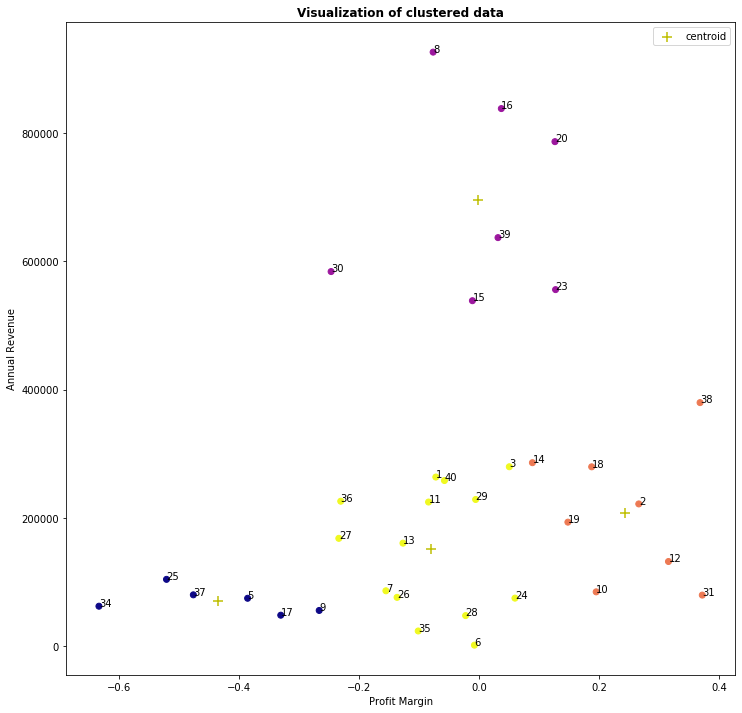

In [50]:
# Defining a function that labels the data points, so that we can refer to specific clients of each cluster easily
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

# seperating the ID of each client, so that we can have easily presentable results for the CEO
df2['Client ID'] = df2['Client #'].str.split(" ",expand=False).str[1]

# Plot the clustered data
fig, ax = plt.subplots(figsize=(12, 12))

plt.scatter(df2['Profit Margin'], df2['Annual Revenue'],
            c=df2['Classification'], cmap = 'plasma')
label_point(df2['Profit Margin'], df2['Annual Revenue'], df2['Client ID'], ax)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='+', s=100,
            c='y', label='centroid')
plt.legend(loc='left')
plt.xlabel('Profit Margin')
plt.ylabel('Annual Revenue')
plt.title('Visualization of clustered data', fontweight='bold')
plt.show()

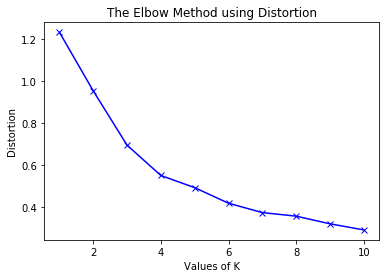

In [15]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,11) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_       # Finalize and render the figure

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

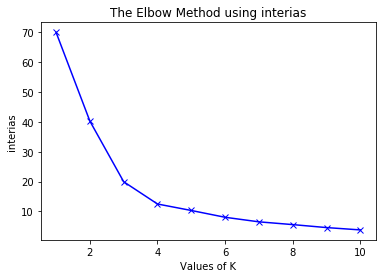

In [16]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('interias') 
plt.title('The Elbow Method using interias') 
plt.show() 

Creating the Metric for Team Building Criteria:

First we need to get the necessary data from our dataframes:

1.   Total Hours worked by each employee per client.
2.   Cost factors (CF) for each employee for each cluster type.
3.   Average hours worked per role per cluster type. (for constraints)



In [17]:
#Merge dataframes 
df = pd.merge(df2,df1, on='Client #', how = 'left')  
df['Designation'].unique()

array(['Accountant', 'Client Manager', 'Controller', 'Financial Analyst',
       'Manager', 'Senior Accountant', 'Business Analyst'], dtype=object)

In [18]:
#define hourly wages:
c_CM = 120
c_Contr = 70
c_SA = 60
c_BA = 60
c_FA = 50
c_Acc = 50
c_Man = 70

#Calculate Total Hours each employee spent on a project based on their (total cost/hourly wage)
conditions = [
    (df['Designation'] == 'Accountant'),
    (df['Designation'] == 'Client Manager') ,
    (df['Designation'] == 'Controller'),
    (df['Designation'] == 'Financial Analyst') ,
    (df['Designation'] == 'Senior Accountant'),
    (df['Designation'] == 'Business Analyst') ,
    (df['Designation'] == 'Manager')
    ]
choices = [df['Employee Cost']/c_Acc,
           df['Employee Cost']/c_CM,
           df['Employee Cost']/c_Contr,
           df['Employee Cost']/c_FA,
           df['Employee Cost']/c_SA,
           df['Employee Cost']/c_BA,
           df['Employee Cost']/c_Man
          ]
df['Hours'] = np.select(conditions, choices, default=np.NaN)

df.head()

,Client #,Annual Revenue,Annual Cost,Annual Profit,Profit Margin,Classification,Client ID,Employee #,Location,Designation,Employee Cost,Hours
0,Client 1,263940.0,282846.0,-18906.0,-0.07163,3,1,Employee 1,BTQ,Accountant,2273.0,45.460000
1,Client 1,263940.0,282846.0,-18906.0,-0.07163,3,1,Employee 2,BTQ,Client Manager,69601.0,580.008333
2,Client 1,263940.0,282846.0,-18906.0,-0.07163,3,1,Employee 3,BTQ,Client Manager,112.0,0.933333
3,Client 1,263940.0,282846.0,-18906.0,-0.07163,3,1,Employee 4,BTQ,Controller,8989.0,128.414286
4,Client 1,263940.0,282846.0,-18906.0,-0.07163,3,1,Employee 5,BTQ,Controller,10253.0,146.471429


In [19]:
#Calculating Client's Total hours spent by employees
Client_hours_total = df.groupby('Client #').sum()['Hours']
#Cleaning
Client_hours_total = pd.DataFrame(Client_hours_total)
Client_hours_total = Client_hours_total.reset_index()
Client_hours_total = Client_hours_total.rename(columns  ={'Hours':'Total'})
Client_hours_total.head(5)

,Client #,Total
0,Client 1,1850.449762
1,Client 10,436.743333
2,Client 11,1866.219048
3,Client 12,413.865476
4,Client 13,1271.566190


In [20]:
#Creating the master dataframe for cost factor calculations
master_df = pd.merge(df,Client_hours_total, on = 'Client #', how = 'left')
master_df.head()

,Client #,Annual Revenue,Annual Cost,Annual Profit,Profit Margin,Classification,Client ID,Employee #,Location,Designation,Employee Cost,Hours,Total
0,Client 1,263940.0,282846.0,-18906.0,-0.07163,3,1,Employee 1,BTQ,Accountant,2273.0,45.460000,1850.449762
1,Client 1,263940.0,282846.0,-18906.0,-0.07163,3,1,Employee 2,BTQ,Client Manager,69601.0,580.008333,1850.449762
2,Client 1,263940.0,282846.0,-18906.0,-0.07163,3,1,Employee 3,BTQ,Client Manager,112.0,0.933333,1850.449762
3,Client 1,263940.0,282846.0,-18906.0,-0.07163,3,1,Employee 4,BTQ,Controller,8989.0,128.414286,1850.449762
4,Client 1,263940.0,282846.0,-18906.0,-0.07163,3,1,Employee 5,BTQ,Controller,10253.0,146.471429,1850.449762


In [0]:
#Calculating Cost Factor for individual employee in every project
master_df['CF_Ind'] = (master_df['Annual Cost']/master_df['Annual Revenue'])*(master_df['Hours']/master_df['Total'])

#Seperating By cluster
y_blue = master_df[master_df['Classification'] == 0]
y_purple = master_df[master_df['Classification'] == 1]
y_orange = master_df[master_df['Classification'] == 2]
y_yellow = master_df[master_df['Classification'] == 3]

#Dropping NANs for employees not considered (new employees or employees who never worked on any project)
y_blue = y_blue.dropna()
y_purple = y_purple.dropna()
y_orange = y_orange.dropna()
y_yellow = y_yellow.dropna()

#Creating Individual Cost Factors for Every Employee seperated by cluster type
y_blue_CF = pd.DataFrame(y_blue.groupby('Employee #').mean()['CF_Ind'])
y_blue_CF = y_blue_CF.reset_index()
y_blue_CF = y_blue_CF.rename( columns = {'CF_Ind':'CF_blue'})

y_purple_CF = pd.DataFrame(y_purple.groupby('Employee #').mean()['CF_Ind'])
y_purple_CF = y_purple_CF.reset_index()
y_purple_CF = y_purple_CF.rename( columns = {'CF_Ind':'CF_purple'})

y_orange_CF = pd.DataFrame(y_orange.groupby('Employee #').mean()['CF_Ind'])
y_orange_CF = y_orange_CF.reset_index()
y_orange_CF = y_orange_CF.rename( columns = {'CF_Ind':'CF_orange'})


y_yellow_CF = pd.DataFrame(y_yellow.groupby('Employee #').mean()['CF_Ind'])
y_yellow_CF = y_yellow_CF.reset_index()
y_yellow_CF = y_yellow_CF.rename( columns = {'CF_Ind':'CF_yellow'})

In [0]:
#Creating a matrix for every employee and their respective CF for each cluster
Employee_list = pd.DataFrame(df['Employee #'].unique(), columns = ['Employee #'])
merge_1 = pd.merge(Employee_list,y_blue_CF, on='Employee #', how='left')
merge_2 = pd.merge(merge_1,y_purple_CF, on='Employee #', how='left')
merge_3 = pd.merge(merge_2,y_orange_CF, on='Employee #', how='left')
CF_Matrix = pd.merge(merge_3,y_yellow_CF, on='Employee #', how='left')

In [23]:
#Every employee did not work in every cluster y
CF_Matrix.isna().sum()

Employee #     0
CF_blue       42
CF_purple     29
CF_orange     49
CF_yellow     23
dtype: int64

In [0]:
#Add respective Designations to the Cost Factor Matrix and sorting them by Designation
designation_df = pd.DataFrame()
designation_df[['Employee #','Designation']] = df1[['Employee #','Designation']]
designation_df = designation_df.drop_duplicates().drop(index = [30,39]) # there were employees with two roles ==> had that clarified with BTQ and drop the wrong roles
CF_Matrix = pd.merge(CF_Matrix,designation_df,on = 'Employee #', how = 'left')
CF_Matrix = CF_Matrix.sort_values(['Designation'])

In [25]:
#Business Analyst Cost Factors are NaNs because these two clusters do not require Business Analysts
#We will replace Business Analyst Cost Factor NaNs and all Nans with 1 to penlize the employees with no historical cost factor
#Wanting to see average Cost Factor by Role for every Cluster
CF_Matrix.groupby('Designation').mean()

,CF_blue,CF_purple,CF_orange,CF_yellow
Designation,,,,
Accountant,0.065683,0.031830,0.046493,0.029111
Business Analyst,NaN,NaN,0.018264,0.000686
Client Manager,0.177710,0.076906,0.155342,0.135206
Controller,0.170449,0.080597,0.078287,0.116046
Financial Analyst,0.158151,0.184260,0.115291,0.067814
Manager,0.064065,0.008495,0.026627,0.038859
Senior Accountant,0.061361,0.048506,0.051595,0.095556


In [26]:
# Average Cost Factor by cluster to assign to roles in each cluster given client attribute simulation.
np.mean(CF_Matrix.groupby('Designation').mean(), axis = 0)

CF_blue      0.116236
CF_purple    0.071766
CF_orange    0.070271
CF_yellow    0.069040
dtype: float64

In [0]:
CF_Matrix = CF_Matrix.fillna(1) # maximum penalization for employees with no history for clients in that cluster

In [28]:
#define hourly wages:
c_CM = 120
c_Contr = 70
c_SA = 60
c_BA = 60
c_FA = 50
c_Acc = 50
c_Man = 70
#Inputting hourly wage
conditions = [
    (CF_Matrix ['Designation'] == 'Accountant'),
    (CF_Matrix ['Designation'] == 'Client Manager') ,
    (CF_Matrix ['Designation'] == 'Controller'),
    (CF_Matrix ['Designation'] == 'Financial Analyst') ,
    (CF_Matrix ['Designation'] == 'Senior Accountant'),
    (CF_Matrix ['Designation'] == 'Business Analyst') ,
    (CF_Matrix ['Designation'] == 'Manager')
    ]
choices = [c_Acc,
           c_CM,
           c_Contr,
           c_FA,
           c_SA,
           c_BA,
           c_Man
          ]
CF_Matrix['c_e'] = np.select(conditions, choices, default=np.NaN)
CF_Matrix

,Employee #,CF_blue,CF_purple,CF_orange,CF_yellow,Designation,c_e
0,Employee 1,0.076714,1.000000,0.067878,0.088825,Accountant,50.0
36,Employee 47,0.008571,0.096263,0.065717,0.069624,Accountant,50.0
37,Employee 48,0.013125,0.039584,0.060738,0.002594,Accountant,50.0
45,Employee 57,0.081455,0.022710,1.000000,0.045041,Accountant,50.0
46,Employee 58,1.000000,0.066664,0.012012,1.000000,Accountant,50.0
...,...,...,...,...,...,...,...
12,Employee 21,1.000000,1.000000,1.000000,0.022885,Senior Accountant,60.0
11,Employee 20,0.262457,1.000000,1.000000,0.111560,Senior Accountant,60.0
66,Employee 82,0.006333,0.041857,1.000000,0.044312,Senior Accountant,60.0
77,Employee 91,0.003964,0.033009,0.042916,1.000000,Senior Accountant,60.0


In [0]:
#separating cost factor matrix by roles to create lists to call on later
CF_cm = CF_Matrix[CF_Matrix['Designation']=='Client Manager']
CF_cntr = CF_Matrix[CF_Matrix['Designation']=='Controller']
CF_acct = CF_Matrix[CF_Matrix['Designation']=='Accountant']
CF_ba = CF_Matrix[CF_Matrix['Designation']=='Business Analyst']
CF_fa = CF_Matrix[CF_Matrix['Designation']=='Financial Analyst']
CF_mngr = CF_Matrix[CF_Matrix['Designation']=='Manager']
CF_sracct = CF_Matrix[CF_Matrix['Designation']=='Senior Accountant']

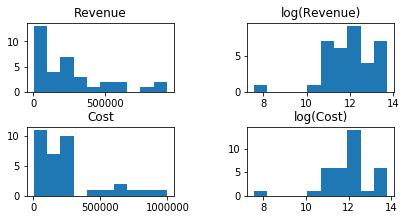

In [30]:
#Plotting histograms to see variable distributions
fig, axs = plt.subplots(2,2)

(ax1,ax2) , (ax3,ax4) = axs

ax1.hist(df2['Annual Revenue'].values)
ax1.set_title("Revenue")
ax2.hist(np.log(df2['Annual Revenue'].values))
ax2.set_title("log(Revenue)")


ax3.hist(df2['Annual Cost'].values)
ax3.set_title("Cost")
ax4.hist(np.log(df2['Annual Cost'].values))
ax4.set_title("log(Cost)")

plt.subplots_adjust(top=0.7, bottom=0.1, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.5)

We can see from the histograms that a log transform is needed for both variables

Scatter Plot of Cost VS Revenue


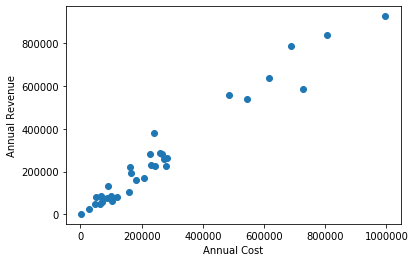

In [31]:
#A strong linear relationship can be obeserved in the scatter plot between Cost and Revenue
print('Scatter Plot of Cost VS Revenue')
plt.scatter(df2['Annual Cost'].values,df2['Annual Revenue'].values)
plt.xlabel('Annual Cost')
plt.ylabel('Annual Revenue')
plt.show()

In [32]:
#Seeing the Correlation between the variables
print('Correlation Table')
df2[['Annual Cost','Annual Revenue']].corr()

Correlation Table


,Annual Cost,Annual Revenue
Annual Cost,1.000000,0.979219
Annual Revenue,0.979219,1.000000


In [33]:
#Creating a linear regression to predict the annual cost based on revenue achieved from the client
#Since we know which model we will be using in order to implement for our client, cross-validation and model selection is not needed
#Revenue is known as soon as BTQ is willing to on-board a client
df2[['Annual_Cost','Annual_Revenue']] = df2[['Annual Cost','Annual Revenue']]
model_regression = ols("np.log(Annual_Cost) ~ np.log(Annual_Revenue)", data = df2).fit()
print(model_regression.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(Annual_Cost)   R-squared:                       0.963
Model:                             OLS   Adj. R-squared:                  0.961
Method:                  Least Squares   F-statistic:                     849.3
Date:                 Wed, 18 Dec 2019   Prob (F-statistic):           3.98e-25
Time:                         15:21:24   Log-Likelihood:                 2.7652
No. Observations:                   35   AIC:                            -1.530
Df Residuals:                       33   BIC:                             1.580
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

In [34]:
#Creating predictions:
new_clients_revenue_input = 7000 #update this number with new client revenue
new_revenue = pd.DataFrame([new_clients_revenue_input], columns = ['Annual_Revenue'])
cost_pred = np.exp(model_regression.predict(new_revenue))

#Calculate profit margin
new_profit_margin = (new_revenue.values - cost_pred.values )/new_revenue.values
new_client = pd.DataFrame([[new_profit_margin,new_revenue.values]], columns=['Profit Margin','Annual Revenue'])

#Standardize values and predict cluster
X = new_client[['Profit Margin','Annual Revenue']].values
X = scaler.transform(X)
predict_cluster = KMeans_Cluster.predict(X)

print('New Client will be in Cluster:',predict_cluster[0])

New Client will be in Cluster: 3


In [35]:
#Finding out which index to grab team members from
if predict_cluster[0] == 0:
  cluster_name = 'blue'
elif predict_cluster[0] == 1:
  cluster_name = 'purple'
elif predict_cluster[0] == 2:
  cluster_name = 'orange'
elif predict_cluster[0] == 3:
  cluster_name = 'yellow'
index = 'CF_'+ cluster_name

#Creating Team based on minimum CF(lowest,second lowest or third lowest):
avg_cost = []
for x in range(0,1000):
  #I create a random integer to index either the first, second or third minimum cost factor employee
  i = np.random.randint(0,3)
  client_manager = CF_cm.sort_values(index).iloc[i,0]
  i = np.random.randint(0,3)
  client_controller = CF_cntr.sort_values(index).iloc[i,0]
  i = np.random.randint(0,3) 
  client_acct = CF_acct.sort_values(index).iloc[i,0]
  i = np.random.randint(0,1) # only two business analysts
  client_ba = CF_ba.sort_values(index).iloc[i,0]
  i = np.random.randint(0,3)
  client_fa = CF_fa.sort_values(index).iloc[i,0] 
  i = np.random.randint(0,1)
  client_mngr = CF_mngr.sort_values(index).iloc[i,0]
  i = np.random.randint(0,3)
  client_sa = CF_sracct.sort_values(index).iloc[i,0] 

  #If a client needs a business analyst or not (Based on historical teams constructed in the data)
  if predict_cluster[0] == 0 or predict_cluster[0] == 3 :
    new_team = [client_manager,client_controller,client_acct,client_ba,client_fa,client_mngr,client_sa]
  else:
    new_team = [client_manager,client_controller,client_acct,client_fa,client_mngr,client_sa]

  #Retrieving each team member's average cost for that type of project:
  new_cost = []
  for x in new_team:
    cost_of_emp = master_df.loc[(master_df['Classification']==predict_cluster[0]) &(master_df['Employee #']== x ) ].groupby('Employee #').mean()['Employee Cost'].values
    new_cost.append(cost_of_emp)
  total_cost = np.sum(new_cost)
  if total_cost>0:
    avg_cost.append(total_cost)
cost_of_team_CF = np.mean(avg_cost)
cost_of_team_CF_std = np.std(avg_cost)
print('Total Cost of efficient team:',cost_of_team_CF)
print('Standard Deviation of Simulation:',cost_of_team_CF_std)

Total Cost of efficient team: 7958.200250000001
Standard Deviation of Simulation: 2325.648945724215


In [36]:
#Finding out which index to grab team members from
if predict_cluster[0] == 0:
  cluster_name = 'blue'
elif predict_cluster[0] == 1:
  cluster_name = 'purple'
elif predict_cluster[0] == 2:
  cluster_name = 'orange'
elif predict_cluster[0] == 3:
  cluster_name = 'yellow'
index = 'CF_'+ cluster_name


total_savings_list = []
#Creating Team based on a random sampling from each Designation
for i in range(0,1000):
  client_manager = CF_cm.sample(1).iloc[0,0]
  client_controller = CF_cntr.sample(1).iloc[0,0] 
  client_acct = CF_acct.sample(1).iloc[0,0] 
  client_ba = CF_ba.sample(1).iloc[0,0] 
  client_fa = CF_fa.sample(1).iloc[0,0] 
  client_mngr = CF_mngr.sample(1).iloc[0,0] 
  client_sa = CF_sracct.sample(1).iloc[0,0] 

  #If the team needs a business analyst or not
  if predict_cluster[0] == 0 or predict_cluster[0] == 3 :
    new_team = [client_manager,client_controller,client_acct,client_ba,client_fa,client_mngr,client_sa]
  else:
    new_team = [client_manager,client_controller,client_acct,client_fa,client_mngr,client_sa]
  
  #Retrieving each team member's average cost for that type of project:
  new_cost = []
  for x in new_team:
    cost_of_emp = master_df.loc[(master_df['Classification']==predict_cluster[0]) &(master_df['Employee #']== x ) ].groupby('Employee #').mean()['Employee Cost'].values
    new_cost.append(cost_of_emp)
  total_cost_2 = np.sum(new_cost)
  
  #to remove costs of an employee never worked in a project type and has no cost factor associated:
  if total_cost_2>0:
    total_savings_list.append(total_cost_2)

Cost_of_random_team = np.mean(total_savings_list)
Cost_of_random_team_std = np.std(total_savings_list)
print('BTQ current team assignment theoretically cost:', Cost_of_random_team)
print('Standard Deviation of Simulation:',Cost_of_random_team_std)

BTQ current team assignment theoretically cost: 42703.992728442725
Standard Deviation of Simulation: 17819.69341442288


In [37]:
print('Decrease in BTQ cost from efficiently assigning teams based on CF:',((Cost_of_random_team-cost_of_team_CF)/Cost_of_random_team)*100,'%')

Decrease in BTQ cost from efficiently assigning teams based on CF: 81.3642712506845 %
